In [1]:
%matplotlib inline
import sys
sys.path.append("../../../agnpy")
import numpy as np
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
from agnpy.particles import Blob
from astropy.coordinates import Distance
from agnpy.synchrotron import Synchrotron
from agnpy.compton import Compton
from agnpy.targets import RingDustTorus, SphericalShellBLR

# electron densities

In [2]:
spectrum_norm = 1e-2 * u.Unit("cm-3")
parameters = {
    "p1": 2.0001,
    "p2": 3.5,
    "gamma_b": 1e4,
    "gamma_min": 20,
    "gamma_max": 5e7,
}
spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters}
R_b = 1e16 * u.cm
B = 0.56 * u.G
z = 1
delta_D = 40
Gamma = 40
blob = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)
blob.set_gamma_size(800)

normalizing power-law to total particle density: 1.00e-02 cm-3


In [3]:
from jetset.jet_model import Jet
jet = Jet(name='test',electron_distribution='bkn')
jet.set_par('B',val=blob.B)
jet.set_par('N',val=blob.norm.value)
jet.set_par('R',val=np.log10(blob.R_b))
jet.set_par('beam_obj',val=blob.delta_D)
jet.set_par('gmin',val=blob.gamma_min)
jet.set_par('gmax',val=blob.gamma_max)
jet.set_par('gamma_break',val=blob.n_e.gamma_b)
jet.set_par('p',val=blob.n_e.p1)
jet.set_par('p_1',val=blob.n_e.p2)
jet.set_par('z_cosm',val=blob.z)
jet.set_gamma_grid_size(1000)
jet.show_pars()

-------------------------------------------------------------------------------------------------------------------
model parameters:
 Name             | Type                 | Units            | value         | phys. boundaries              | log
-------------------------------------------------------------------------------------------------------------------
 B                | magnetic_field       | G                | +5.600000e-01 | [+0.000000e+00,No           ] | False 
 N                | electron_density     | cm^-3            | +1.000170e-02 | [+0.000000e+00,No           ] | False 
 R                | region_size          | cm               | +1.600000e+01 | [+0.000000e+00,+3.000000e+01] | True 
 beam_obj         | beaming              |                  | +4.000000e+01 | [+1.000000e+00,No           ] | False 
 gamma_break      | turn-over-energy     | Lorentz-factor   | +1.000000e+04 | [+1.000000e+00,+1.000000e+08] | False 
 gmax             | high-energy-cut-off  | Lorentz-f

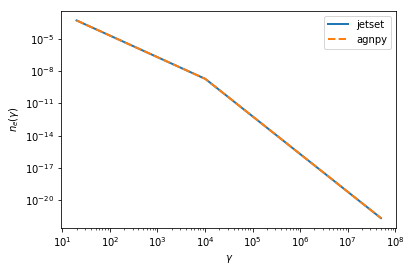

total density 1.00e-02 1 / cm3
total energy 4.72e+42 erg


In [4]:
plt.loglog(jet.electron_distribution.gamma, jet.electron_distribution.n_gamma, lw=2, label="jetset")
plt.loglog(blob.gamma, blob.n_e(blob.gamma), lw=2, ls="--", label="agnpy")
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$n_e(\gamma)$")
plt.legend()
plt.show()
print(f"total density {blob.norm:.2e}")
print(f"total energy {blob.W_e:.2e}")

In [5]:
distances = [1e18, 1e20, 1e21] * u.cm

In [6]:
# torus parameters
M_sun = const.M_sun.cgs
M_BH = 1.2 * 1e9 * M_sun
L_disk = 2 * 1e46 * u.Unit("erg s-1")
T_dt = 1e3 * u.K
epsilon_dt = 2.7 * ((const.k_B * T_dt) / (const.m_e * const.c * const.c)).decompose()
csi_dt = 0.1

dt1 = RingDustTorus(M_BH, L_disk, csi_dt, epsilon_dt, r=distances[0])
dt2 = RingDustTorus(M_BH, L_disk, csi_dt, epsilon_dt, r=distances[1])
dt3 = RingDustTorus(M_BH, L_disk, csi_dt, epsilon_dt, r=distances[2])

print(dt1.R_dt)

1.5652475842498533e+19


In [7]:
dt1.set_phi_size(800)
compton = Compton(blob)

nu = np.logspace(15, 30, 50) * u.Hz
sed1 = compton.sed_flux_ring_torus(nu, dt1)
sed2 = compton.sed_flux_ring_torus(nu, dt2)
sed3 = compton.sed_flux_ring_torus(nu, dt3)

agnpy_seds = [sed1, sed2, sed3]

# Torus Comparison

In [8]:
jet.add_EC_component("EC_DT")
jet.spectral_components.Sync.state="off"
jet.show_pars()

-------------------------------------------------------------------------------------------------------------------
model parameters:
 Name             | Type                 | Units            | value         | phys. boundaries              | log
-------------------------------------------------------------------------------------------------------------------
 B                | magnetic_field       | G                | +5.600000e-01 | [+0.000000e+00,No           ] | False 
 N                | electron_density     | cm^-3            | +1.000170e-02 | [+0.000000e+00,No           ] | False 
 R                | region_size          | cm               | +1.600000e+01 | [+0.000000e+00,+3.000000e+01] | True 
 R_DT             | DT                   | cm               | +5.000000e+18 | [+0.000000e+00,No           ] | False 
 T_DT             | DT                   | K                | +1.000000e+02 | [+0.000000e+00,No           ] | False 
 beam_obj         | beaming              |          

In [9]:
jet.set_par("tau_DT", dt1.csi_dt)
jet.set_par("T_DT", dt1.T_dt)
jet.set_par("R_DT", dt1.R_dt)

nu_seds = []
jetset_seds = []

for distance in distances:
    jet._blob.R_H = distance.value
    jet.eval()
    x, y = jet.get_SED_points(name="EC_DT")
    nu_seds.append(x)
    jetset_seds.append(y)

Text(0, 0.5, '$\\nu F_{\\nu} / (erg\\,cm^{-2}\\,s^{-1})$')

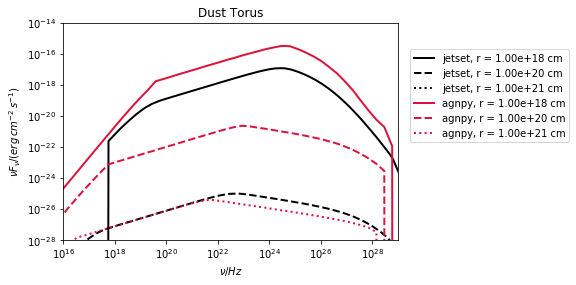

In [10]:
for freq, sed, r, ls in zip(nu_seds, jetset_seds, distances, ("-", "--", ":")):
    plt.loglog(freq, sed, lw=2, ls=ls, color="k", label=f"jetset, r = {r:.2e}")

for sed, dt, ls in zip(agnpy_seds, (dt1, dt2, dt3), ("-", "--", ":")):
    plt.loglog(nu, sed, lw=2, color="crimson", ls=ls, label=f"agnpy, r = {dt.r:.2e} cm")

plt.legend(bbox_to_anchor=[1.02, 0.9])
plt.title("Dust Torus")
plt.ylim([1e-28, 1e-14])
plt.xlim([1e16, 1e29])
plt.xlabel(r"$\nu / Hz$")
plt.ylabel(r"$\nu F_{\nu} / (erg\,cm^{-2}\,s^{-1})$")

# BLR comparison

In [11]:
distances = [1e16, 1e18, 1e19] * u.cm

epsilon_line = 2e-5
csi_line = 0.024
R_line = 1e17 * u.cm

blob.set_gamma_size(500)

blr1 = SphericalShellBLR(M_BH, L_disk, csi_line, epsilon_line, R_line, r=distances[0])
blr2 = SphericalShellBLR(M_BH, L_disk, csi_line, epsilon_line, R_line, r=distances[1])
blr3 = SphericalShellBLR(M_BH, L_disk, csi_line, epsilon_line, R_line, r=distances[2])

blr3.set_mu_size(80)

sed1 = compton.sed_flux_shell_blr(nu, blr1)
sed2 = compton.sed_flux_shell_blr(nu, blr2)
sed3 = compton.sed_flux_shell_blr(nu, blr3)

agnpy_seds = [sed1, sed2, sed3]

In [12]:
jet.add_EC_component("EC_BLR")
jet.show_pars()

-------------------------------------------------------------------------------------------------------------------
model parameters:
 Name             | Type                 | Units            | value         | phys. boundaries              | log
-------------------------------------------------------------------------------------------------------------------
 B                | magnetic_field       | G                | +5.600000e-01 | [+0.000000e+00,No           ] | False 
 L_Disk           | Disk                 | erg/s            | +1.000000e+45 | [+0.000000e+00,No           ] | False 
 N                | electron_density     | cm^-3            | +1.000170e-02 | [+0.000000e+00,No           ] | False 
 R                | region_size          | cm               | +1.600000e+01 | [+0.000000e+00,+3.000000e+01] | True 
 R_BLR_in         | BLR                  | cm               | +1.000000e+18 | [+0.000000e+00,No           ] | False 
 R_BLR_out        | BLR                  | cm       

In [13]:
jet.set_par("tau_BLR", blr1.csi_line)
jet.set_par("R_BLR_in", blr1.R_line)
jet.set_par("R_BLR_out", 2 * blr1.R_line)

nu_seds = []
jetset_seds = []

for distance in distances:
    jet._blob.R_H = distance.value
    jet.eval()
    x, y = jet.get_SED_points(name="EC_BLR")
    nu_seds.append(x)
    jetset_seds.append(y)

Text(0, 0.5, '$\\nu F_{\\nu} / (erg\\,cm^{-2}\\,s^{-1})$')

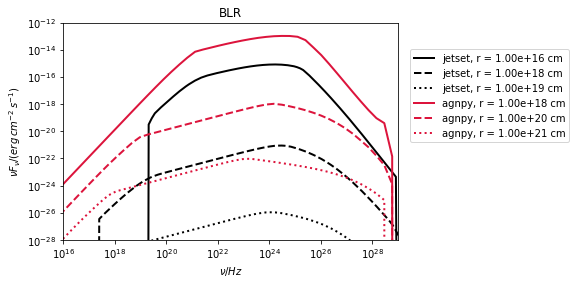

In [14]:
for freq, sed, r, ls in zip(nu_seds, jetset_seds, distances, ("-", "--", ":")):
    plt.loglog(freq, sed, lw=2, ls=ls, color="k", label=f"jetset, r = {r:.2e}")

for sed, dt, ls in zip(agnpy_seds, (dt1, dt2, dt3), ("-", "--", ":")):
    plt.loglog(nu, sed, lw=2, color="crimson", ls=ls, label=f"agnpy, r = {dt.r:.2e} cm")

plt.title("BLR")
plt.legend(bbox_to_anchor=[1.02, 0.9])
plt.ylim([1e-28, 1e-12])
plt.xlim([1e16, 1e29])
plt.xlabel(r"$\nu / Hz$")
plt.ylabel(r"$\nu F_{\nu} / (erg\,cm^{-2}\,s^{-1})$")